In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from edgedroid.models.timings import *
import edgedroid.data as default_data

exec_time_data, neuroticism_data, imp_data, dur_data = default_data.load_default_exec_time_data()

data = preprocess_data(exec_time_data, neuroticism_data, imp_data, dur_data)
data

,run_id,ttf,next_exec_time,neuroticism,neuroticism_raw,impairment,duration,transition,duration_raw
0,134146,0.000000,3.654797,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,1
1,134146,0.597441,4.438645,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,2
2,134146,0.553513,2.943222,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,3
3,134146,0.561716,5.405761,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,4
4,134146,0.586512,5.225161,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[5.0, 10.0)",NoTransition,5
...,...,...,...,...,...,...,...,...,...
6755,137353,0.577341,6.439071,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,6
6756,137353,0.557074,4.680858,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,7
6757,137353,0.534339,3.467878,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,8
6758,137353,0.560288,2.325759,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,9


In [2]:
import itertools
from collections import deque
import pandas as pd
from typing import Tuple, Deque
from tqdm.notebook import tqdm

result_rows = deque()

for run_id in tqdm(data["run_id"].unique(), desc="Run"):
    test_data = data[data["run_id"] == run_id].copy()

    def get_test_data(*args, **kwargs) \
            -> Tuple[pd.DataFrame, pd.arrays.IntervalArray, pd.arrays.IntervalArray, pd.arrays.IntervalArray]:
        etime_data = exec_time_data[exec_time_data["run_id"] != run_id].copy()
        return etime_data, neuroticism_data, imp_data, dur_data

    class EmpiricalTestModel(EmpiricalETM):
        get_data = get_test_data

    class TheoreticalTestModel(FittedETM):
        get_data = get_test_data


    neuroticism = test_data["neuroticism_raw"].unique()[0]

    models: Deque[Tuple[str, ExecutionTimeModel, int, int]] = deque()

    for win_size, ttf_bins in itertools.product(range(1, 16), range(1, 10)):
        emp_model = EmpiricalTestModel(neuroticism=neuroticism,
                                       ttf_levels=ttf_bins,
                                       cleanup=CleanupMode.TRUNCATE,
                                       window=win_size)
        theo_model = TheoreticalTestModel(neuroticism=neuroticism,
                                          ttf_levels=ttf_bins,
                                          cleanup=CleanupMode.TRUNCATE,
                                          window=win_size)

        models.extend((
            ("empirical", emp_model, win_size, ttf_bins),
            ("theoretical", theo_model, win_size, ttf_bins)
        ))

    for _ in range(30):
        for i, (prev_ttf, exec_time) in enumerate(test_data[["ttf", "next_exec_time"]].itertuples(index=False)):
            for model_name, model, win_size, ttf_bins in models:
                if i == 0:
                    # reset the model between runs
                    model.reset()
                else:
                    # first row has no previous ttf
                    model.advance(prev_ttf)

                prediction = model.get_execution_time()
                result_rows.append({
                    "real": exec_time,
                    "prediction": prediction,
                    "error": prediction - exec_time,
                    "model": model_name,
                    "window": win_size,
                    "ttf_bins": ttf_bins
                })

results = pd.DataFrame(result_rows)
results

Run:   0%|          | 0/40 [00:00<?, ?it/s]

,real,prediction,error,model,window,ttf_bins
0,3.654797,6.363172,2.708375,empirical,1,1
1,3.654797,5.156027,1.501230,theoretical,1,1
2,3.654797,4.759005,1.104208,empirical,1,2
3,3.654797,5.883962,2.229165,theoretical,1,2
4,3.654797,7.683459,4.028662,empirical,1,3
...,...,...,...,...,...,...
54755995,4.615283,5.903438,1.288155,theoretical,15,7
54755996,4.615283,3.391942,-1.223341,empirical,15,8
54755997,4.615283,5.981850,1.366566,theoretical,15,8
54755998,4.615283,4.288043,-0.327241,empirical,15,9


In [3]:
results["sqr_error"] = np.square(results["error"])
results

,real,prediction,error,model,window,ttf_bins,sqr_error
0,3.654797,6.363172,2.708375,empirical,1,1,7.335297
1,3.654797,5.156027,1.501230,theoretical,1,1,2.253691
2,3.654797,4.759005,1.104208,empirical,1,2,1.219274
3,3.654797,5.883962,2.229165,theoretical,1,2,4.969175
4,3.654797,7.683459,4.028662,empirical,1,3,16.230118
...,...,...,...,...,...,...,...
54755995,4.615283,5.903438,1.288155,theoretical,15,7,1.659343
54755996,4.615283,3.391942,-1.223341,empirical,15,8,1.496564
54755997,4.615283,5.981850,1.366566,theoretical,15,8,1.867503
54755998,4.615283,4.288043,-0.327241,empirical,15,9,0.107086


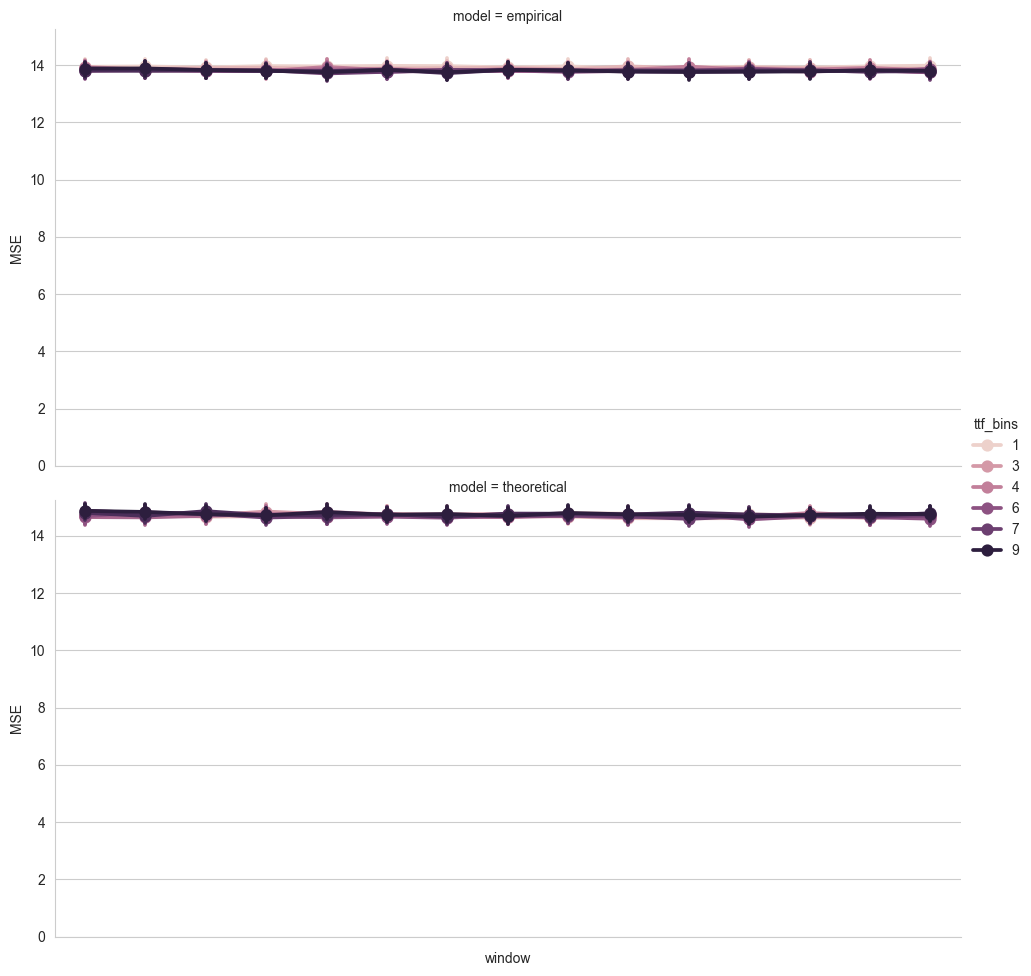

In [4]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fg = sns.catplot(results, kind="point", x="window", y="sqr_error", hue="ttf_bins", row="model", height=5, aspect=2)
fg.set(ylim=(0, None))
fg.set_ylabels("MSE")
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()